In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %load_ext line_profiler

In [2]:
from semantic_segmentation_tile import SemanticSegmentationTile
from pathlib import Path

In [3]:
max_tile_size = 256
bs = 8
max_tol = 50

In [4]:
path = Path("dataset_segmentation/")
path_lbl = path / "labels"
path_img = path / "images"
path_img_cbg = path / "custom_bg" / "0000_random_rotation"

Idea: change background on the fly as a transformation

In [21]:
segm = SemanticSegmentationTile(path_img_cbg, path_lbl, max_tile_size=max_tile_size, bs=bs, max_tol=max_tol, transforms=[])

Creating Dataset of images of total size: (3149, 2219);
number of rows: 13, columns: 9;
size of tiles: (246, 242);
discared pixels due to rounding y: 5 x: 3
created Dataset with in: 11981 tiles train and 2995 in valid 
creating learner ...
done


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


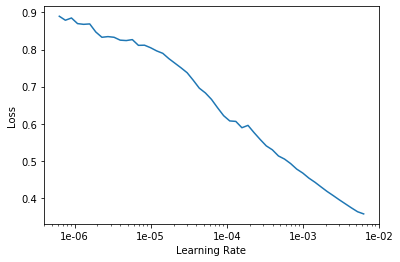

In [22]:
segm.learn.lr_find()
segm.learn.recorder.plot()

In [23]:
segm.learn.fit_one_cycle(4, 2e-4)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.004937,0.002037,0.999253,31:53
1,0.000922,0.000864,0.999715,31:53
2,0.000466,0.000417,0.999863,31:54
3,0.000347,0.000373,0.999880,31:54


### need to unfreeze model

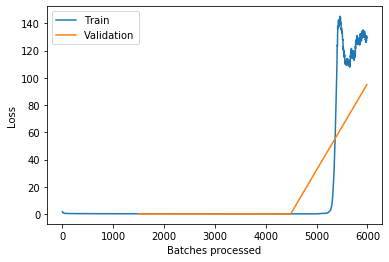

In [17]:
segm.learn.recorder.plot_losses()

In [13]:
# segm.learn.save("trainig_bg_0000_lr_0.003_freezed_2_epoch")

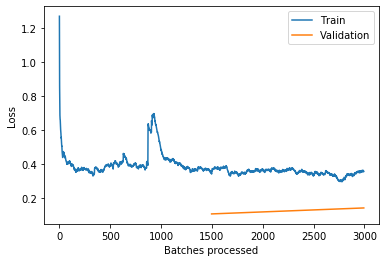

In [11]:
segm.learn.recorder.plot_losses()

# OLD Impletation in Notebook

evaluate to use fastai size convention for everything and get rid of this conversion mess (need to work map correctly cols and rows to axes).

**MUST Do this**

In [2]:
from pathlib import Path
from collections import namedtuple, deque
from functools import lru_cache

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
img = open_image("test_tile.png")
img.size

torch.Size([1086, 714])

In [6]:
def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [35]:
ImageTile = namedtuple('ImageTile', 'path idx rows cols')

#Need to find a better name!
def best_block_divide(sz, max_blk_sz, max_tol):
    """sz: size of the original input
        max_blk_sz: max block size (returned block size must be <=)
        max_tol: max number of elements left, espressed in number of elements.

        finds the min number of block that satisfies this conditions
        returns tuple of:
        n_blocks, block_size, n_elem_left
        """
    blk_sz = max_blk_sz
    # migrate to walrus operator in py 3.8
    diff = (sz % blk_sz)
    # try with smaller blk_size until the diff is <= max_diff
    # edge case is blk_size=1 which means diff==0
    while diff > max_tol:
        blk_sz -= 1
        diff = (sz % blk_sz)
    return sz // blk_sz, blk_sz, sz % blk_sz
def calc_n_tiles(size, tile_max_size, max_tol=30):
    """returns the \"best\" size for the tile given the image size.
    return type is a tuple of (n_blocks, block_size, n_elem_left)"""
    x, y = size
    x = best_block_divide(x, tile_max_size, max_tol)
    y = best_block_divide(y, tile_max_size, max_tol)
    return x,y

def get_label(path):
    return path_lbl / path.name

def get_labels_tiles(fn):
    path, *tile = fn
    path = get_label(path)
    return ImageTile(path, *tile)


def get_tiles(images: PathOrStr, rows: int, cols: int) -> Collection[ImageTile]:
    images_tiles = []
    for img in images:
        for i in range(rows * cols):
            images_tiles.append(ImageTile(img, i, rows, cols))
    return images_tiles

@lru_cache(maxsize=20)
def open_image_cached(*args, **kwargs): return open_image(*args, **kwargs)

@lru_cache(maxsize=20)
def open_mask_cached(*args, **kwargs): return open_mask(*args, **kwargs)

        
def open_image_tile(img_t: ImageTile, mask=False, **kwargs) -> Image:
    # TODO fix this
    """given and ImageTile it returns and Image with the tile,
    set mask to True for masks, indexes increase going down on columns from the top left tile, till the bottom right tile"""
    # looks like it is rather slow, maybe increase performance by caching latest open images? 
    path, idx, rows, cols = img_t
    # swap rows with columns due to pytorch image 'style' (height x width)
    rows, cols = cols, rows
    #caches the last    
    img = open_image_cached(path ,**kwargs) if not mask else open_mask_cached(path, **kwargs)
    row = idx // cols
    col = idx % cols
    tile_x = img.size[0] // cols
    tile_y = img.size[1] // rows
    return Image(img.data[:, col * tile_x:(col + 1) * tile_x, row * tile_y:(row + 1) * tile_y])


class SegmentationTileLabelList(SegmentationLabelList):

    def open(self, fn: ImageTile):
        return open_image_tile(fn, div=True, mask=True)


class SegmentationTileItemList(ImageList):
    _label_cls, _square_show_res = SegmentationTileLabelList, False

    # accepts as inputs a tuple of TileInfo and PathOrStr
    def open(self, fn: ImageTile) -> Image:
        return open_image_tile(fn, convert_mode=self.convert_mode, after_open=self.after_open)

    @classmethod
    def from_folder(cls, path: PathOrStr = '.', rows=1, cols=1, extensions: Collection[str] = None, **kwargs) -> ItemList:
        """Create an `ItemList` in `path` from the filenames that have a suffix in `extensions`.
        `recurse` determines if we search subfolders."""
        files = get_files(path, extensions, recurse=True)
        files_tiled = get_tiles(files, rows, cols)
        return SegmentationTileItemList(files_tiled, **kwargs)

this cells defines globals variable required by other functions

In [38]:
#calc number tiles with hardcoded sizes
# NB img_size is (height, width), which is equal to (x,y) and (rows, cols)
img_size = (3149, 2219)
(rows, x_tile, x_diff), (cols, y_tile, y_diff) = calc_n_tiles(img_size, max_tile_size, max_tol)
print(x_tile, y_tile)
print(rows, cols)
print(x_diff,y_diff)

242 246
13 9
3 5


In [34]:
best_block_divide(3149, 256, 50)

(13, 242, 3)

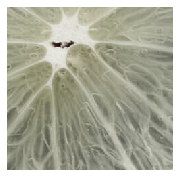

In [41]:
st = SegmentationTileItemList.from_folder(path_img, rows, cols)
i = st[30]
st.split_by_rand_pct()
show_image(i)

TODO add tranforms and debug get_transforms() issues

In [42]:
codes = ['background','fruit']
data = (SegmentationTileItemList
    .from_folder(path_img, rows, cols)
    .split_by_rand_pct()
    .label_from_func(get_labels_tiles, classes=codes)
    .transform([])
    .databunch(bs=bs)
    .normalize(imagenet_stats))


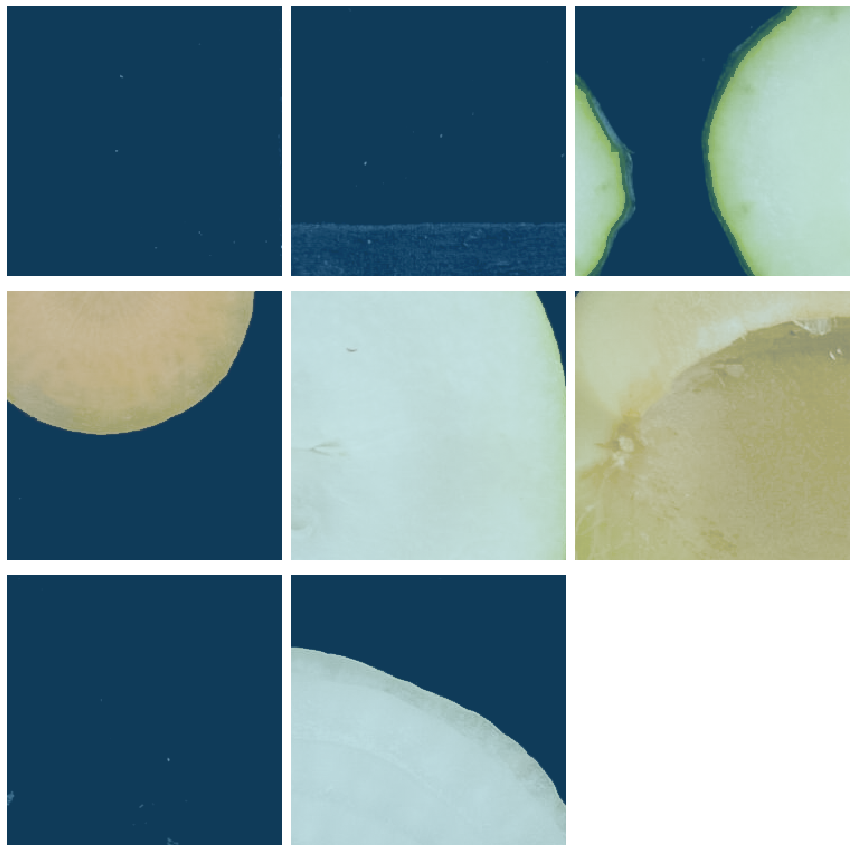

In [44]:
data.show_batch() #why last is empty??

In [45]:
learn = unet_learner(data, models.resnet34, metrics=seg_accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


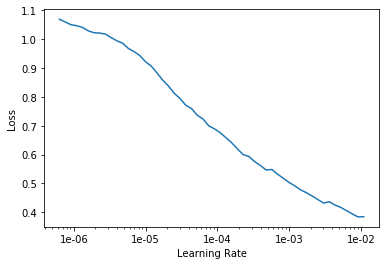

In [46]:
lr_find(learn)
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.014845,0.010195,0.996522,32:31


In [48]:
learn.fit_one_cycle(2, 1e-4)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.011088,0.006362,0.997723,32:24
1,0.006424,0.004828,0.998149,32:26


testing model with the custom bg

In [ ]:
inf_learn = 

In [11]:
inf_learn = unet_learner(data, models.resnet34, metrics=seg_accuracy).load("1run_test1")

In [ ]:
%%capture cap

In [14]:
def predict_mask(img_path):
    #uses all the global variables that are output of calc_n_tiles(), maybe refactor
    i = 0
    end_mask = None #sentinel value for first iteration
    for col in range(cols):
        col_mask = None
        for row in range(rows):
            img_tile = open_image_tile(ImageTile(img_path, idx=i, rows=rows, cols=cols))
            mask_tile, _, _ = inf_learn.predict(img_tile)
            mask_tile = mask_tile.data.permute(1,2,0) #convert to numpy style it is the way to think about the image
            col_mask = np.vstack((col_mask, mask_tile)) if col_mask is not None else mask_tile
            i += 1
        end_mask = np.hstack((end_mask, col_mask)) if end_mask is not None else col_mask
    #add padding to make pred_mask size the same of the original image
    pred_mask = torch.zeros((*img_size, 1), dtype=torch.long) # iniziatlize mask with correct size with all black
    pred_mask[:-x_diff,:-y_diff, :] = torch.tensor(end_mask).permute(1,0,2) #copy mask on the all black background
    return Image(pred_mask.permute(2,1,0)) #convert back to pytorch image style

In [94]:
im = predict_mask(path_img / "albicocche1.png")

In [12]:
def seg_test_image_tile(img: ImageTile, real_mask: ImageTile):
    pred_mask, _, _ = inf_learn.predict(open_image_tile(img))
    real_mask = open_image_tile(real_mask, div=True, mask=True)
    wrong = np.count_nonzero(pred_mask.data != real_mask.data)    
    intersection = np.logical_and(real_mask.data, pred_mask.data)
    union = np.logical_or(real_mask.data, pred_mask.data)
    iou_score = torch.div(torch.sum(intersection),torch.sum(union).float())
    
    return iou_score, wrong

In [13]:
#warning img_size: number of pixels
def seg_benchmark_tile(path_img):
    "benchmarks the full dataset in path_img analysing the single tiles"
    imgs = get_image_files(path_img)
    imgs = get_tiles(imgs, rows, cols)
    masks = [get_labels_tiles(f) for f in imgs]
    wrongs = torch.empty(len(imgs), dtype=torch.float32)
    iou_scores = torch.empty(len(imgs), dtype=torch.float32)
    for i, img, mask in zip(range(len(imgs)), imgs, masks):
        iou_score, wrong = seg_test_image_tile(img, mask)
        wrongs[i] = wrong
        iou_scores[i] = iou_score
                            
    wrong_perc = torch.mean(wrongs) * 100 / 
    print(f"perc of wrong pixels: {wrong_perc}%")
    print(f"mean accuracy: {100-wrong_perc}%")
    print(f"max wrong per image: {torch.max(wrongs)} over {img_size} pixels")
    print(f"mean IoU: {torch.mean(iou_scores)}")
    print(f"min IoU: {torch.min(iou_scores)}")

In [32]:
seg_bench_test_tile(4,6, tile_size[0]*tile_size[1])

perc of wrong pixels: 0.7767105102539062%
mean accuracy: 99.2232894897461%
max wrong per image: 38950.0 over 290296 pixels
mean IoU: nan
min IoU: nan


In [108]:
def seg_test_full_image(img_p):
    pred_mask = predict_mask(img_p)
    real_mask = open_mask(get_label(img_p), div=True) 
    pred_mask, real_mask = pred_mask.data, real_mask.data
    wrong = np.count_nonzero(pred_mask != real_mask)
    
    intersection = np.logical_and(real_mask, pred_mask)
    union = np.logical_or(real_mask, pred_mask)
    iou_score = torch.div(torch.sum(intersection),torch.sum(union).float())
    
    return iou_score, wrong

In [109]:
seg_test_full_image(path_img / "albicocche1.png")

(tensor(0.9972), 10064)

In [ ]:
def plot_pixel_difference_tile(img, real_mask, figsize=(20,20)):
    img = open_image_tile(img)
    pred_mask, _, _ = inf_learn.predict(img)
    real_mask = open_image_tile(real_mask, mask=True, div=True)
    real_mask = image2np(real_mask.data)
    pred_mask = image2np(pred_mask.data)
    img = image2np(img.data)
    diff = pred_mask != real_mask
    img[diff==1] = (1, 0 ,0) # 0000FF is blue FF0000 is red
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
img_path_t = path_img / "albicocche1.png"
img_t = ImageTile(path_img / "albicocche1.png", 0, 4, 6)
mask_t = get_labels_tiles(img_t)
plot_pixel_difference_tile(img_t, mask_t)

In [12]:
def plot_pixel_difference_image(img_p, mask_p, figsize=(20,20)):
    img = open_image(img_p)
    pred_mask = predict_mask(img_p)
    real_mask = open_mask(mask_p, div=True)
    real_mask = image2np(real_mask.data)
    pred_mask = image2np(pred_mask.data)
    img = image2np(img.data)
    diff = pred_mask != real_mask
#     breakpoint()
    img[diff==1] = (1, 0 ,0) # 0000FF is blue FF0000 is red
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)

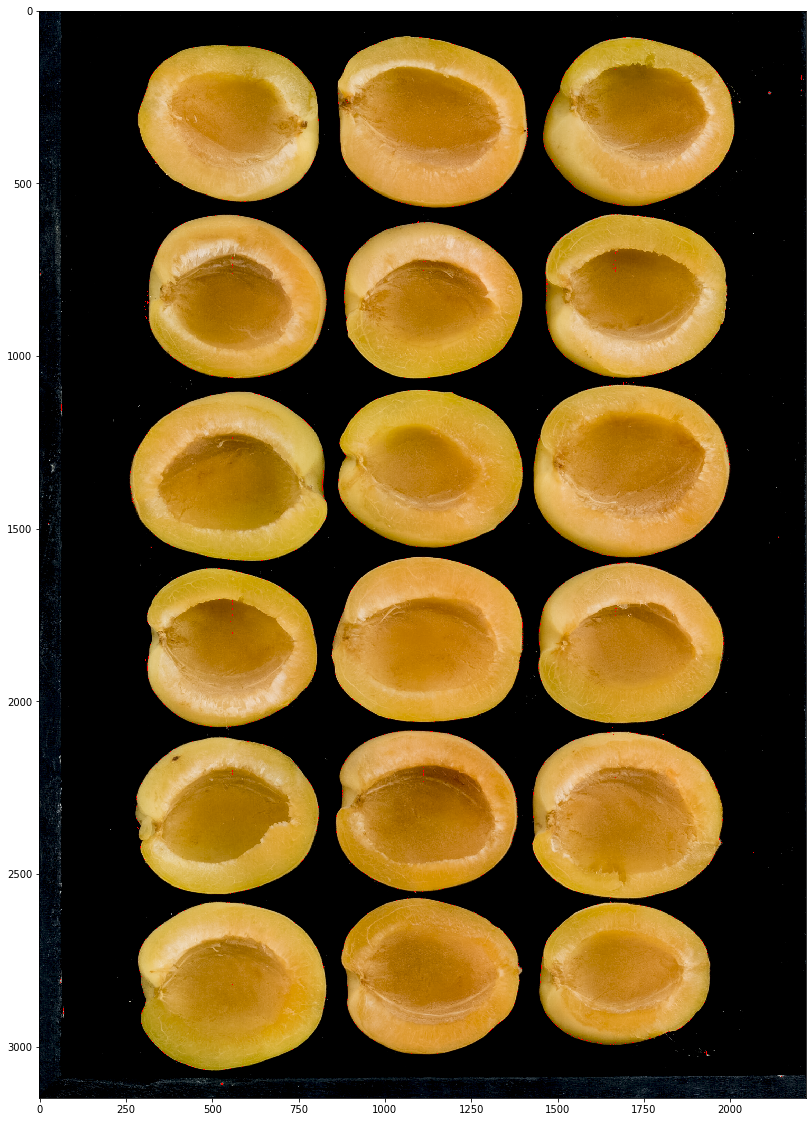

In [15]:
img_p = path_img / "albicocche1.png"
mask_p = get_label(img_p)
plot_pixel_difference_full(img_p, mask_p)